In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# COMBINE MULTIPLE YEAR DATA FILES WITH UNIQUE PATIENT IDENTIFICATION
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

print("="*80)
print("COMBINING MULTI-YEAR MEDICAL DATA WITH UNIQUE PATIENT IDS")
print("="*80)

COMBINING MULTI-YEAR MEDICAL DATA WITH UNIQUE PATIENT IDS


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# ============================================================================
# STEP 1: LOAD BOTH YEAR FILES
# ============================================================================
print("\n📁 Step 1: Loading data from both years...")

# Load year 1401 data
df_1401 = pd.read_excel("Results1401.xlsx")
print(f"✓ Year 1401: {len(df_1401)} records, {df_1401['PID'].nunique()} unique PIDs")

# Load year 1402 data
df_1402 = pd.read_excel("Results1402.xlsx")
print(f"✓ Year 1402: {len(df_1402)} records, {df_1402['PID'].nunique()} unique PIDs")

# ============================================================================
# STEP 2: CREATE UNIQUE IDENTIFIERS
# ============================================================================
print("\n🔑 Step 2: Creating unique patient identifiers...")

# Add year column to each dataset
df_1401['Year'] = 1401
df_1402['Year'] = 1402

# Create unique patient ID by combining Year and PID
df_1401['UniqueID'] = df_1401['Year'].astype(str) + '_' + df_1401['PID'].astype(str)
df_1402['UniqueID'] = df_1402['Year'].astype(str) + '_' + df_1402['PID'].astype(str)

print(f"✓ Created unique IDs for year 1401 (e.g., {df_1401['UniqueID'].iloc[0]})")
print(f"✓ Created unique IDs for year 1402 (e.g., {df_1402['UniqueID'].iloc[0]})")

# ============================================================================
# STEP 3: COMBINE THE DATASETS
# ============================================================================
print("\n🔄 Step 3: Combining datasets...")

df_combined = pd.concat([df_1401, df_1402], ignore_index=True)

print(f"✓ Combined dataset: {len(df_combined)} total records")
print(f"✓ Total unique patients: {df_combined['UniqueID'].nunique()}")
print(f"✓ Years included: {df_combined['Year'].unique()}")

# ============================================================================
# STEP 4: PROCESS COMBINED DATA (IMPROVED)
# ============================================================================
print("\n🧹 Step 4: Processing combined data...")

def process_result(value):
    """
    Convert various result formats to numeric values
    Handles: numbers, strings with asterisks, negative/positive markers
    """
    try:
        # Already numeric
        if isinstance(value, (int, float)):
            return float(value)
        
        # Handle string values
        if isinstance(value, str):
            # Remove whitespace
            value = value.strip()
            
            # Skip empty or non-numeric markers
            if value == '' or value.lower() in ['negative', 'positive', 'positive(+)', 'a']:
                return None
            
            # Remove asterisk if present (e.g., "228 *" -> "228")
            if '*' in value:
                value = value.replace('*', '').strip()
            
            # Remove < and > symbols (e.g., "<5" -> "5")
            value = value.replace('<', '').replace('>', '').strip()
            
            # Handle fractions (e.g., "3/5" -> average)
            if '/' in value:
                parts = value.split('/')
                numeric_parts = []
                for part in parts:
                    try:
                        numeric_parts.append(float(part.strip()))
                    except:
                        pass
                if numeric_parts:
                    return np.mean(numeric_parts)
                return None
            
            # Replace comma with period for decimal values
            value = value.replace(",", ".")
            
            # Convert to float
            return float(value)
            
        # If not string or number, return None
        return None
        
    except (ValueError, TypeError):
        return None

# Process Result column
df_combined["Result"] = df_combined["Result"].apply(process_result)
valid_results = df_combined["Result"].notna().sum()
print(f"✓ Processed results: {valid_results}/{len(df_combined)} valid numeric values")

# Show examples of processed values
print("\nSample processed values:")
sample_results = df_combined[df_combined["Result"].notna()].head(10)
for idx, row in sample_results.iterrows():
    print(f"  {row['TName']}: {row['Result']}")


# ============================================================================
# STEP 5: CREATE TARGET VARIABLE (IMPROVED WITH 3 CRITERIA)
# ============================================================================
print("\n🎯 Step 5: Creating target variable based on T2D criteria...")
print("Criteria for T2D (Type 2 Diabetes):")
print("  1. Fasting Blood Sugar (قند ناشتا) >= 100")
print("  2. 2-Hour Blood Sugar (قند دو ساعته) >= 140")
print("  3. HbA1c >= 6.5")

# Initialize flag column
df_combined["T2D_Flag"] = 0

# Criterion 1: Fasting Blood Sugar >= 100
fasting_mask = (
    (df_combined["TName"].str.contains("Fasting", case=False, na=False)) &
    (pd.notna(df_combined["Result"])) &
    (df_combined["Result"] >= 100)
)
df_combined.loc[fasting_mask, "T2D_Flag"] = 1

# Criterion 2: 2-Hour Blood Sugar >= 140
# Common names: "BS 2hpp", "2HPP", "2 hour post prandial", etc.
two_hour_mask = (
    (
        df_combined["TName"].str.contains("2hpp|2 hpp|2HPP|2 hour|two hour", case=False, na=False, regex=True)
    ) &
    (pd.notna(df_combined["Result"])) &
    (df_combined["Result"] >= 140)
)
df_combined.loc[two_hour_mask, "T2D_Flag"] = 1

# Criterion 3: HbA1c >= 6.5
hba1c_mask = (
    (df_combined["TName"].str.contains("Hb A1C|HbA1c|A1C", case=False, na=False, regex=True)) &
    (pd.notna(df_combined["Result"])) &
    (df_combined["Result"] >= 6.5)
)
df_combined.loc[hba1c_mask, "T2D_Flag"] = 1

# Show how many records were flagged by each criterion
print("\nRecords flagged by each criterion:")
print(f"  Fasting Blood Sugar >= 100: {fasting_mask.sum()} records")
print(f"  2-Hour Blood Sugar >= 140: {two_hour_mask.sum()} records")
print(f"  HbA1c >= 6.5: {hba1c_mask.sum()} records")
print(f"  Total flagged records: {df_combined['T2D_Flag'].sum()}")

# Map to patient level using UniqueID
# If ANY test for a patient meets the criteria, that patient is flagged as T2D
pid_target = df_combined.groupby("UniqueID")["T2D_Flag"].max()
df_combined["Target"] = df_combined["UniqueID"].map(pid_target)
df_combined = df_combined.drop(columns=["T2D_Flag"])

# Check target distribution by year
print("\nTarget distribution by year:")
for year in [1401, 1402]:
    year_data = df_combined[df_combined['Year'] == year]
    target_dist = year_data.groupby('UniqueID')['Target'].first().value_counts()
    total = target_dist.sum()
    
    print(f"\nYear {year}:")
    print(f"  Non-diabetic (0): {target_dist.get(0, 0)} patients ({target_dist.get(0, 0)/total*100:.1f}%)")
    print(f"  Diabetic (1): {target_dist.get(1, 0)} patients ({target_dist.get(1, 0)/total*100:.1f}%)")

# Optional: Show detailed breakdown by criterion for patients
print("\n📊 Detailed T2D detection breakdown:")
for year in [1401, 1402]:
    year_data = df_combined[df_combined['Year'] == year].copy()
    
    # Count patients meeting each criterion
    fasting_patients = year_data[
        (year_data["TName"].str.contains("Fasting", case=False, na=False)) &
        (pd.notna(year_data["Result"])) &
        (year_data["Result"] >= 100)
    ]["UniqueID"].nunique()
    
    two_hour_patients = year_data[
        (year_data["TName"].str.contains("2hpp|2 hpp|2HPP|2 hour|two hour", case=False, na=False, regex=True)) &
        (pd.notna(year_data["Result"])) &
        (year_data["Result"] >= 140)
    ]["UniqueID"].nunique()
    
    hba1c_patients = year_data[
        (year_data["TName"].str.contains("Hb A1C|HbA1c|A1C", case=False, na=False, regex=True)) &
        (pd.notna(year_data["Result"])) &
        (year_data["Result"] >= 6.5)
    ]["UniqueID"].nunique()
    
    print(f"\nYear {year} - Patients meeting each criterion:")
    print(f"  Fasting BS >= 100: {fasting_patients} patients")
    print(f"  2-Hour BS >= 140: {two_hour_patients} patients")
    print(f"  HbA1c >= 6.5: {hba1c_patients} patients")
# ============================================================================
# STEP 6: PIVOT COMBINED DATA
# ============================================================================
print("\n📊 Step 6: Pivoting combined data...")

df_grouped = df_combined.groupby(['UniqueID', 'TName', 'Target', 'Year'])['Result'].mean().reset_index()

df_pivot = df_grouped.pivot(index=['UniqueID', 'Target', 'Year'], 
                            columns='TName', 
                            values='Result').reset_index()

print(f"✓ Pivoted data: {df_pivot.shape[0]} unique patients × {df_pivot.shape[1]-3} features")

# ============================================================================
# STEP 7: HANDLE MISSING VALUES
# ============================================================================
print("\n🔧 Step 7: Handling missing values...")

for col in df_pivot.columns:
    if col not in ['UniqueID', 'Target', 'Year']:
        median_val = df_pivot[col].median()
        if pd.notna(median_val):
            df_pivot[col] = df_pivot[col].fillna(median_val)
        else:
            df_pivot[col] = df_pivot[col].fillna(0)

print("✓ Missing values filled with median per test")

# ============================================================================
# STEP 8: PREPARE FOR MACHINE LEARNING
# ============================================================================
print("\n🎯 Step 8: Preparing for machine learning...")

X = df_pivot.drop(['UniqueID', 'Target', 'Year'], axis=1)
y = df_pivot['Target']
years = df_pivot['Year']
unique_ids = df_pivot['UniqueID']

print(f"✓ Feature matrix: {X.shape}")
print(f"✓ Target vector: {y.shape}")

# ============================================================================
# STEP 9: CREATE TRAIN-TEST SPLIT
# ============================================================================
print("\n✂️ Step 9: Creating train-test split...")

# Option 1: Random split
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, unique_ids,
    test_size=0.2, 
    random_state=2, 
    stratify=y
)

print("\n📊 Option 1 - Random Split:")
print(f"Training: {len(X_train)} patients")
print(f"Testing: {len(X_test)} patients")

# Option 2: Time-based split
train_mask = years == 1401
test_mask = years == 1402

X_train_time = X[train_mask]
X_test_time = X[test_mask]
y_train_time = y[train_mask]
y_test_time = y[test_mask]

print("\n📊 Option 2 - Time-based Split:")
print(f"Training (1401): {len(X_train_time)} patients")
print(f"Testing (1402): {len(X_test_time)} patients")

# ============================================================================
# STEP 10: SAVE COMBINED DATA
# ============================================================================
print("\n💾 Step 10: Saving processed data...")

df_pivot.to_excel("combined_data_1401_1402_pivoted.xlsx", index=False)
print("✓ Saved combined pivoted data")

df_combined.to_excel("combined_data_1401_1402_raw.xlsx", index=False)
print("✓ Saved combined raw data")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("✅ DATA COMBINATION COMPLETE")
print("="*80)
print(f"\nCombined Statistics:")
print(f"• Total unique patients: {df_pivot['UniqueID'].nunique()}")
print(f"• Total features: {X.shape[1]}")
print(f"• Years included: 1401, 1402")
print(f"• Class distribution: {y.value_counts().to_dict()}")

print("\n✓ Variables ready for use:")
print("  - X_train, X_test, y_train, y_test (random split)")
print("  - X_train_time, X_test_time, y_train_time, y_test_time (time split)")

# Convert to 1D arrays for sklearn
y_train = np.ravel(y_train)
y_train_time = np.ravel(y_train_time)


📁 Step 1: Loading data from both years...
✓ Year 1401: 48465 records, 2659 unique PIDs
✓ Year 1402: 32930 records, 2097 unique PIDs

🔑 Step 2: Creating unique patient identifiers...
✓ Created unique IDs for year 1401 (e.g., 1401_2)
✓ Created unique IDs for year 1402 (e.g., 1402_1)

🔄 Step 3: Combining datasets...
✓ Combined dataset: 81395 total records
✓ Total unique patients: 4756
✓ Years included: [1401 1402]

🧹 Step 4: Processing combined data...
✓ Processed results: 75685/81395 valid numeric values

Sample processed values:
  Fasting blood sugar: 71.68
  Urea: 29.7
  Uric Acid: 6.4
  Cholesterol Total: 228.0
  Triglycerides: 214.91
  Creatinine: 0.86
  W.B.C: 8300.0
  R.B.C: 5.9
  Hemoglobin: 16.0
  Hematocrit: 48.0

🎯 Step 5: Creating target variable based on T2D criteria...
Criteria for T2D (Type 2 Diabetes):
  1. Fasting Blood Sugar (قند ناشتا) >= 100
  2. 2-Hour Blood Sugar (قند دو ساعته) >= 140
  3. HbA1c >= 6.5

Records flagged by each criterion:
  Fasting Blood Sugar >= 100


METHOD 1: ANOVA F-TEST

Top 20 features by F-test:
                       Feature      F_Score        P_Value
142        Fasting blood sugar  1148.982233  2.651265e-220
181                     Hb A1C   278.904336   1.770500e-60
79      Blood Sugar (2 hr p.p)   130.329283   1.052081e-29
304              Triglycerides    62.493617   3.474163e-15
184                 Hematocrit    60.573475   9.070421e-15
150              Free.Beta.HCG    57.606061   4.004341e-14
185                 Hemoglobin    54.334879   2.063701e-13
213                      M.C.V    52.906162   4.227484e-13
330           VLDL Cholesterol    51.954956   6.816673e-13
31                     APTT-LA    43.204545   5.600598e-11
311                       Urea    34.073344   5.751069e-09
315  Urine Calcium-Ca (Random)    31.949580   1.698485e-08
218                  Monocytes    31.195665   2.496209e-08
116                 Creatinine    29.907453   4.823336e-08
135                      F-ANA    26.041096   3.505736e-07
331 

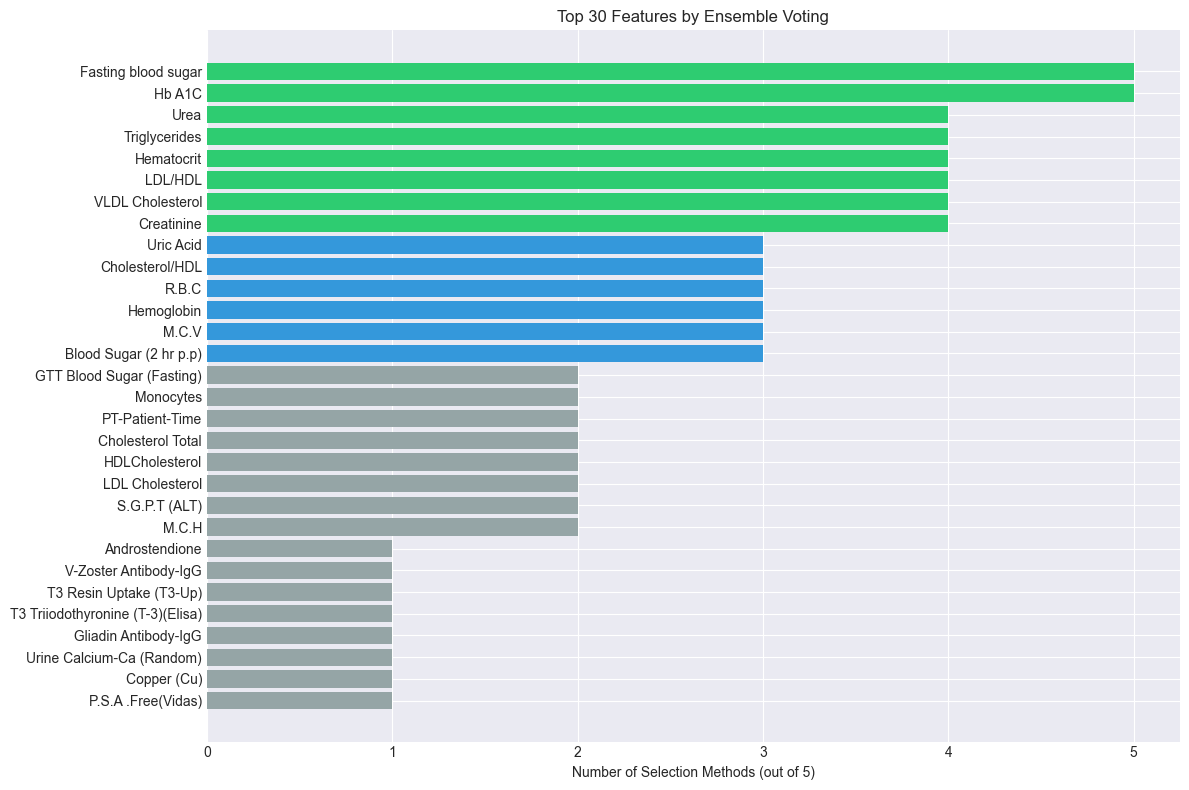

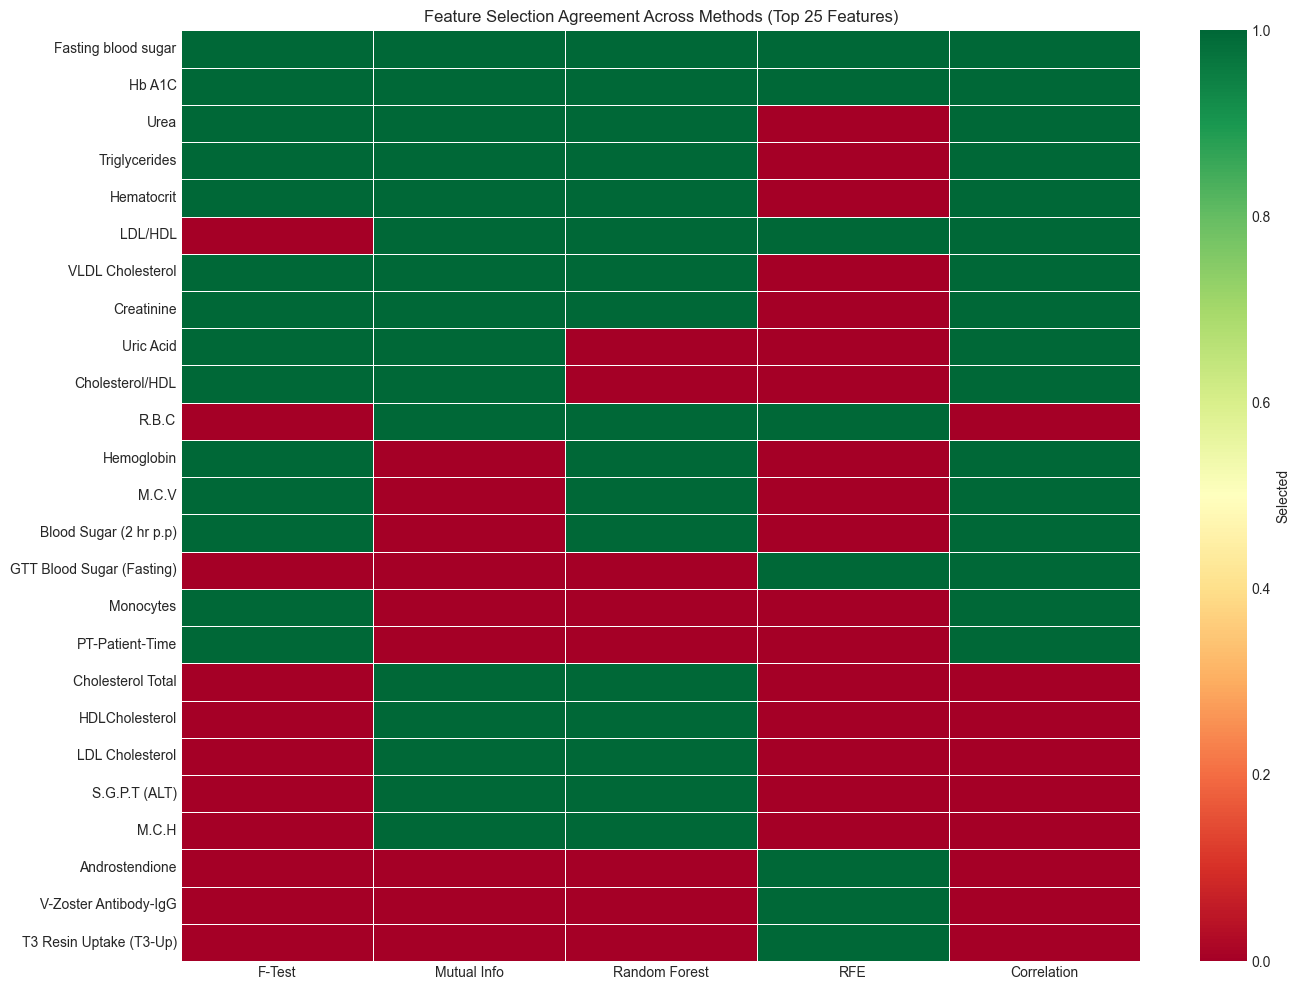


✅ FEATURE SELECTION COMPLETE

📊 Summary:
• Original features: 348
• Selected features: 20
• Reduction: 94.3%

🎯 Variables ready for modeling:
  - X_train_reduced, X_test_reduced (random split)
  - X_train_time_reduced, X_test_time_reduced (time split)
  - selected_features_ensemble (list of feature names)

📁 Files saved:
  - feature_selection_results.xlsx
  - feature_selection_votes.png
  - feature_selection_heatmap.png


In [38]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import (
    SelectKBest, 
    f_classif, 
    mutual_info_classif,
    RFE
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# METHOD 1: STATISTICAL TESTS (ANOVA F-test)
# ============================================================================
print("\n" + "="*80)
print("METHOD 1: ANOVA F-TEST")
print("="*80)

selector_f = SelectKBest(score_func=f_classif, k=20)
selector_f.fit(X_train, y_train)

# Get feature scores
feature_scores_f = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Score': selector_f.scores_,
    'P_Value': selector_f.pvalues_
}).sort_values('F_Score', ascending=False)

print("\nTop 20 features by F-test:")
print(feature_scores_f.head(20))

selected_features_f = feature_scores_f.head(20)['Feature'].tolist()

# ============================================================================
# METHOD 2: MUTUAL INFORMATION
# ============================================================================
print("\n" + "="*80)
print("METHOD 2: MUTUAL INFORMATION")
print("="*80)

selector_mi = SelectKBest(score_func=mutual_info_classif, k=20)
selector_mi.fit(X_train, y_train)

feature_scores_mi = pd.DataFrame({
    'Feature': X_train.columns,
    'MI_Score': selector_mi.scores_
}).sort_values('MI_Score', ascending=False)

print("\nTop 20 features by Mutual Information:")
print(feature_scores_mi.head(20))

selected_features_mi = feature_scores_mi.head(20)['Feature'].tolist()

# ============================================================================
# METHOD 3: RANDOM FOREST FEATURE IMPORTANCE
# ============================================================================
print("\n" + "="*80)
print("METHOD 3: RANDOM FOREST FEATURE IMPORTANCE")
print("="*80)

rf = RandomForestClassifier(n_estimators=100, random_state=2, n_jobs=-1)
rf.fit(X_train, y_train)

feature_importance_rf = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 20 features by Random Forest:")
print(feature_importance_rf.head(20))

selected_features_rf = feature_importance_rf.head(20)['Feature'].tolist()

# ============================================================================
# METHOD 4: RECURSIVE FEATURE ELIMINATION (RFE)
# ============================================================================
print("\n" + "="*80)
print("METHOD 4: RECURSIVE FEATURE ELIMINATION (RFE)")
print("="*80)

lr_rfe = LogisticRegression(max_iter=1000, random_state=2)
rfe = RFE(estimator=lr_rfe, n_features_to_select=20, step=10)
rfe.fit(X_train, y_train)

feature_ranking_rfe = pd.DataFrame({
    'Feature': X_train.columns,
    'Selected': rfe.support_,
    'Ranking': rfe.ranking_
}).sort_values('Ranking')

print("\nTop 20 features by RFE:")
print(feature_ranking_rfe[feature_ranking_rfe['Selected']].head(20))

selected_features_rfe = feature_ranking_rfe[feature_ranking_rfe['Selected']]['Feature'].tolist()

# ============================================================================
# METHOD 5: CORRELATION-BASED SELECTION
# ============================================================================
print("\n" + "="*80)
print("METHOD 5: CORRELATION WITH TARGET")
print("="*80)

# Calculate correlation with target
correlations = []
for col in X_train.columns:
    corr = np.abs(np.corrcoef(X_train[col], y_train)[0, 1])
    correlations.append((col, corr))

feature_corr = pd.DataFrame(correlations, columns=['Feature', 'Correlation'])
feature_corr = feature_corr.sort_values('Correlation', ascending=False)

print("\nTop 20 features by correlation:")
print(feature_corr.head(20))

selected_features_corr = feature_corr.head(20)['Feature'].tolist()

# ============================================================================
# ENSEMBLE: COMBINE ALL METHODS
# ============================================================================
print("\n" + "="*80)
print("ENSEMBLE: VOTING ACROSS ALL METHODS")
print("="*80)

# Count how many times each feature was selected
feature_votes = {}
all_selections = [
    selected_features_f,
    selected_features_mi,
    selected_features_rf,
    selected_features_rfe,
    selected_features_corr
]

for features in all_selections:
    for feature in features:
        feature_votes[feature] = feature_votes.get(feature, 0) + 1

# Sort by votes
feature_votes_df = pd.DataFrame(
    list(feature_votes.items()),
    columns=['Feature', 'Votes']
).sort_values('Votes', ascending=False)

print("\nFeature selection votes (max 5 votes):")
print(feature_votes_df.head(30))

# Select top 20 by votes, then by any additional criteria
selected_features_ensemble = feature_votes_df.head(20)['Feature'].tolist()

print(f"\n✓ Final ensemble selection: {len(selected_features_ensemble)} features")
print("\nFinal selected features:")
for i, feat in enumerate(selected_features_ensemble, 1):
    votes = feature_votes_df[feature_votes_df['Feature'] == feat]['Votes'].values[0]
    print(f"{i:2d}. {feat:40s} (votes: {votes}/5)")

# ============================================================================
# CREATE REDUCED DATASETS
# ============================================================================
print("\n" + "="*80)
print("CREATING REDUCED DATASETS")
print("="*80)

# Create reduced training and test sets
X_train_reduced = X_train[selected_features_ensemble]
X_test_reduced = X_test[selected_features_ensemble]

# For time-based split
X_train_time_reduced = X_train_time[selected_features_ensemble]
X_test_time_reduced = X_test_time[selected_features_ensemble]

print(f"\n✓ Original shape: {X_train.shape}")
print(f"✓ Reduced shape: {X_train_reduced.shape}")
print(f"\nFeature reduction: {X_train.shape[1]} → {X_train_reduced.shape[1]} features")
print(f"Reduction rate: {(1 - X_train_reduced.shape[1]/X_train.shape[1])*100:.1f}%")

# ============================================================================
# SAVE RESULTS
# ============================================================================
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

# Save feature selection results
feature_selection_results = {
    'F_Test': feature_scores_f.head(20),
    'Mutual_Info': feature_scores_mi.head(20),
    'Random_Forest': feature_importance_rf.head(20),
    'RFE': feature_ranking_rfe[feature_ranking_rfe['Selected']].head(20),
    'Correlation': feature_corr.head(20),
    'Ensemble_Votes': feature_votes_df
}

# Save to Excel with multiple sheets
with pd.ExcelWriter('feature_selection_results.xlsx') as writer:
    for method, df in feature_selection_results.items():
        df.to_excel(writer, sheet_name=method, index=False)

print("✓ Feature selection results saved to 'feature_selection_results.xlsx'")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

# Plot 1: Feature votes
plt.figure(figsize=(12, 8))
top_30 = feature_votes_df.head(30)
colors = ['#2ecc71' if v >= 4 else '#3498db' if v >= 3 else '#95a5a6' for v in top_30['Votes']]
plt.barh(range(len(top_30)), top_30['Votes'], color=colors)
plt.yticks(range(len(top_30)), top_30['Feature'])
plt.xlabel('Number of Selection Methods (out of 5)')
plt.title('Top 30 Features by Ensemble Voting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_selection_votes.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: feature_selection_votes.png")

# Plot 2: Method comparison heatmap
plt.figure(figsize=(14, 10))
top_features = feature_votes_df.head(25)['Feature'].tolist()

method_matrix = np.zeros((len(top_features), 5))
method_names = ['F-Test', 'Mutual Info', 'Random Forest', 'RFE', 'Correlation']

for i, feature in enumerate(top_features):
    if feature in selected_features_f:
        method_matrix[i, 0] = 1
    if feature in selected_features_mi:
        method_matrix[i, 1] = 1
    if feature in selected_features_rf:
        method_matrix[i, 2] = 1
    if feature in selected_features_rfe:
        method_matrix[i, 3] = 1
    if feature in selected_features_corr:
        method_matrix[i, 4] = 1

sns.heatmap(method_matrix, 
            xticklabels=method_names,
            yticklabels=top_features,
            cmap='RdYlGn',
            cbar_kws={'label': 'Selected'},
            linewidths=0.5)
plt.title('Feature Selection Agreement Across Methods (Top 25 Features)')
plt.tight_layout()
plt.savefig('feature_selection_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization: feature_selection_heatmap.png")

plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("✅ FEATURE SELECTION COMPLETE")
print("="*80)
print("\n📊 Summary:")
print(f"• Original features: {X_train.shape[1]}")
print(f"• Selected features: {len(selected_features_ensemble)}")
print(f"• Reduction: {(1 - len(selected_features_ensemble)/X_train.shape[1])*100:.1f}%")
print(f"\n🎯 Variables ready for modeling:")
print(f"  - X_train_reduced, X_test_reduced (random split)")
print(f"  - X_train_time_reduced, X_test_time_reduced (time split)")
print(f"  - selected_features_ensemble (list of feature names)")
print("\n📁 Files saved:")
print("  - feature_selection_results.xlsx")
print("  - feature_selection_votes.png")
print("  - feature_selection_heatmap.png")
print("="*80)

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    precision_score,
    recall_score,
    f1_score
)
from numpy import mean, std
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize results dictionary
model_results = {}

# Decide which dataset to use
# Option 1: Use reduced features (recommended)
if 'X_train_reduced' in globals():
    X_train_use = X_train_reduced
    X_test_use = X_test_reduced
    print("✓ Using reduced feature set (20 features)")
else:
    # Option 2: Use all features
    X_train_use = X_train
    X_test_use = X_test
    print("✓ Using all features")

# Cross-validation setup
cv = KFold(n_splits=10, random_state=2, shuffle=True)

✓ Using reduced feature set (20 features)


In [11]:
# ============================================================================
# COMPLETE MACHINE LEARNING MODELS FOR T2DM PREDICTION
# ============================================================================

import numpy as np
import pandas as pd
from numpy import mean, std
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
# ============================================================================
# IMPORT REQUIRED LIBRARIES FOR MACHINE LEARNING
# ============================================================================
print("📦 Importing machine learning libraries...")

# Core libraries (if not already imported)
import pandas as pd
import numpy as np

# Sklearn preprocessing and model selection
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Metrics
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)

# Statistics
from numpy import mean, std

# Visualization (optional but recommended)
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize results dictionary
model_results = {}

print("✓ All libraries imported successfully!")
# Store results for comparison
model_results = {}


📦 Importing machine learning libraries...
✓ All libraries imported successfully!


In [41]:
# ============================================================================
# 3.1 LOGISTIC REGRESSION (if not already done)
# ============================================================================
print("\n" + "="*60)
print("3.1 LOGISTIC REGRESSION (LR)")
print("="*60)

# Create and train LR model
LR = LogisticRegression(max_iter=1000)

# Cross-validation
cv = KFold(n_splits=10, random_state=2, shuffle=True)
scores = cross_val_score(LR, X_train_use, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))

# Fit and predict
LR.fit(X_train_use, y_train)
y_pred_lr = LR.predict(X_test_use)

# Results
print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_lr))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr, digits=4))

cf_matrix_LR = confusion_matrix(y_test, y_pred_lr)
model_results['LR'] = {
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr, average='weighted'),
    'recall': recall_score(y_test, y_pred_lr, average='weighted'),
    'f1': f1_score(y_test, y_pred_lr, average='weighted'),
    'model': LR,
    'predictions': y_pred_lr,
    'cv_mean': mean(scores),
    'cv_std': std(scores)
}



3.1 LOGISTIC REGRESSION (LR)
Accuracy for training: 0.9422 (0.0131)
Accuracy for testing: 0.9464

Confusion Matrix:
[[691   3]
 [ 48 210]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9350    0.9957    0.9644       694
           1     0.9859    0.8140    0.8917       258

    accuracy                         0.9464       952
   macro avg     0.9605    0.9048    0.9281       952
weighted avg     0.9488    0.9464    0.9447       952



In [43]:
# ============================================================================
# 3.2 KNN (K-Nearest Neighbors)
# ============================================================================
print("\n" + "="*60)
print("3.2 K-NEAREST NEIGHBORS (KNN)")
print("="*60)

from sklearn.neighbors import KNeighborsClassifier

# Grid search for best parameters
params_knn = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, params_knn, cv=10, scoring='accuracy')
grid_knn.fit(X_train, y_train)

print(f"Best parameters: {grid_knn.best_params_}")

# Create model with best parameters
KNN = KNeighborsClassifier(**grid_knn.best_params_)

# Cross-validation
cv = KFold(n_splits=10, random_state=2, shuffle=True)
scores = cross_val_score(KNN, X_train_use, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))

# Fit and predict
KNN.fit(X_train_use, y_train)
y_pred_knn = KNN.predict(X_test_use)

# Results
print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_knn))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn, digits=4))

cf_matrix_KNN = confusion_matrix(y_test, y_pred_knn)
model_results['KNN'] = {
    'accuracy': accuracy_score(y_test, y_pred_knn),
    'precision': precision_score(y_test, y_pred_knn, average='weighted'),
    'recall': recall_score(y_test, y_pred_knn, average='weighted'),
    'f1': f1_score(y_test, y_pred_knn, average='weighted'),
    'model': KNN,
    'predictions': y_pred_knn,
    'cv_mean': mean(scores),
    'cv_std': std(scores)
}


3.2 K-NEAREST NEIGHBORS (KNN)
Best parameters: {'n_neighbors': 13, 'weights': 'uniform'}
Accuracy for training: 0.9077 (0.0111)
Accuracy for testing: 0.9034

Confusion Matrix:
[[676  18]
 [ 74 184]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9013    0.9741    0.9363       694
           1     0.9109    0.7132    0.8000       258

    accuracy                         0.9034       952
   macro avg     0.9061    0.8436    0.8681       952
weighted avg     0.9039    0.9034    0.8994       952



In [44]:
# ============================================================================
# 3.3 SVM (Support Vector Machine)
# ============================================================================
print("\n" + "="*60)
print("3.5 SUPPORT VECTOR MACHINE (SVM)")
print("="*60)

SVM = SVC(kernel='rbf', random_state=2)

scores = cross_val_score(SVM, X_train_use, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training (CV): %.4f (±%.4f)' % (mean(scores), std(scores)))

SVM.fit(X_train_use, y_train)
y_pred_svm = SVM.predict(X_test_use)

print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_svm))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm, digits=4))

model_results['SVM'] = {
    'accuracy': accuracy_score(y_test, y_pred_svm),
    'precision': precision_score(y_test, y_pred_svm, average='weighted'),
    'recall': recall_score(y_test, y_pred_svm, average='weighted'),
    'f1': f1_score(y_test, y_pred_svm, average='weighted'),
    'model': SVM,
    'predictions': y_pred_svm,
    'cv_mean': mean(scores),
    'cv_std': std(scores)
}



3.5 SUPPORT VECTOR MACHINE (SVM)
Accuracy for training (CV): 0.9098 (±0.0102)
Accuracy for testing: 0.9076

Confusion Matrix:
[[691   3]
 [ 85 173]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8905    0.9957    0.9401       694
           1     0.9830    0.6705    0.7972       258

    accuracy                         0.9076       952
   macro avg     0.9367    0.8331    0.8687       952
weighted avg     0.9155    0.9076    0.9014       952



In [45]:
# ============================================================================
# 3.4 NAIVE BAYES
# ============================================================================
print("\n" + "="*60)
print("3.4 NAIVE BAYES (NB)")
print("="*60)

from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()

# Cross-validation
cv = KFold(n_splits=10, random_state=2, shuffle=True)
scores = cross_val_score(NB, X_train_use, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))

# Fit and predict
NB.fit(X_train_use, y_train)
y_pred_nb = NB.predict(X_test_use)

# Results
print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_nb))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb, digits=4))

cf_matrix_NB = confusion_matrix(y_test, y_pred_nb)
model_results['NB'] = {
    'accuracy': accuracy_score(y_test, y_pred_nb),
    'precision': precision_score(y_test, y_pred_nb, average='weighted'),
    'recall': recall_score(y_test, y_pred_nb, average='weighted'),
    'f1': f1_score(y_test, y_pred_nb, average='weighted'),
    'model': NB,
    'predictions': y_pred_nb,
    'cv_mean': mean(scores),
    'cv_std': std(scores)
}



3.4 NAIVE BAYES (NB)
Accuracy for training: 0.7907 (0.0167)
Accuracy for testing: 0.7794

Confusion Matrix:
[[613  81]
 [129 129]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8261    0.8833    0.8538       694
           1     0.6143    0.5000    0.5513       258

    accuracy                         0.7794       952
   macro avg     0.7202    0.6916    0.7025       952
weighted avg     0.7687    0.7794    0.7718       952



In [47]:
# ============================================================================
# 3.5 DECISION TREE
# ============================================================================
print("\n" + "="*60)
print("3.2 DECISION TREE (DT)")
print("="*60)

DT = DecisionTreeClassifier(random_state=2, max_depth=10)

scores = cross_val_score(DT, X_train_use, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training (CV): %.4f (±%.4f)' % (mean(scores), std(scores)))

DT.fit(X_train_use, y_train)
y_pred_dt = DT.predict(X_test_use)

print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_dt))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt, digits=4))

model_results['DT'] = {
    'accuracy': accuracy_score(y_test, y_pred_dt),
    'precision': precision_score(y_test, y_pred_dt, average='weighted'),
    'recall': recall_score(y_test, y_pred_dt, average='weighted'),
    'f1': f1_score(y_test, y_pred_dt, average='weighted'),
    'model': DT,
    'predictions': y_pred_dt,
    'cv_mean': mean(scores),
    'cv_std': std(scores)
}



3.2 DECISION TREE (DT)
Accuracy for training (CV): 0.9995 (±0.0011)
Accuracy for testing: 1.0000

Confusion Matrix:
[[694   0]
 [  0 258]]

Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       694
           1     1.0000    1.0000    1.0000       258

    accuracy                         1.0000       952
   macro avg     1.0000    1.0000    1.0000       952
weighted avg     1.0000    1.0000    1.0000       952



In [49]:
# ============================================================================
# 3.6 RANDOM FOREST
# ============================================================================
print("\n" + "="*60)
print("3.6 RANDOM FOREST (RF)")
print("="*60)

from sklearn.ensemble import RandomForestClassifier

# Grid search for best parameters
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = RandomForestClassifier(random_state=2)
grid_rf = GridSearchCV(rf_grid, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_use, y_train)

print(f"Best parameters: {grid_rf.best_params_}")

# Create model with best parameters
RF = RandomForestClassifier(**grid_rf.best_params_, random_state=2)

# Cross-validation
cv = KFold(n_splits=10, random_state=2, shuffle=True)
scores = cross_val_score(RF, X_train_use, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print('Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))

# Fit and predict
RF.fit(X_train_use, y_train)
y_pred_rf = RF.predict(X_test_use)

# Results
print('Accuracy for testing: %.4f' % accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, digits=4))

cf_matrix_RF = confusion_matrix(y_test, y_pred_rf)
model_results['RF'] = {
    'accuracy': accuracy_score(y_test, y_pred_rf),
    'precision': precision_score(y_test, y_pred_rf, average='weighted'),
    'recall': recall_score(y_test, y_pred_rf, average='weighted'),
    'f1': f1_score(y_test, y_pred_rf, average='weighted'),
    'model': RF,
    'predictions': y_pred_rf,
    'cv_mean': mean(scores),
    'cv_std': std(scores)
}




3.6 RANDOM FOREST (RF)
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy for training: 0.9853 (0.0082)
Accuracy for testing: 0.9895

Confusion Matrix:
[[694   0]
 [ 10 248]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9858    1.0000    0.9928       694
           1     1.0000    0.9612    0.9802       258

    accuracy                         0.9895       952
   macro avg     0.9929    0.9806    0.9865       952
weighted avg     0.9896    0.9895    0.9894       952



In [22]:
import numpy as np
import pandas as pd
from numpy import mean, std
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [23]:
# ============================================================================
# 3.7 XGBOOST
# ============================================================================
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from numpy import mean, std

print("="*60)
print("XGBOOST WITH DATA VALIDATION")
print("="*60)


XGBOOST WITH DATA VALIDATION


In [50]:
# ============================================================================
# STEP 1: VALIDATE AND FIX DATA
# ============================================================================
print("\n📋 Checking data format...")

# Check data shapes
print(f"X_train shape: {X_train_use.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test_use.shape}")
print(f"y_test shape: {y_test.shape}")

# Ensure y_train is 1D array
if len(y_train.shape) > 1:
    print("⚠️ Converting y_train to 1D array...")
    y_train = np.ravel(y_train)
    print(f"✓ New y_train shape: {y_train.shape}")

# Check for NaN values
if X_train.isna().any().any() if hasattr(X_train_use, 'isna') else np.isnan(X_train).any():
    print("⚠️ Found NaN values in X_train. Filling with 0...")
    if hasattr(X_train_use, 'fillna'):
        X_train = X_train_use.fillna(0)
        X_test = X_test_use.fillna(0)
    else:
        X_train_use = np.nan_to_num(X_train)
        X_test_use = np.nan_to_num(X_test)
    print("✓ NaN values filled")

# Convert to numpy arrays if they're DataFrames
if hasattr(X_train, 'values'):
    X_train_np = X_train.values
    X_test_np = X_test.values
else:
    X_train_np = X_train
    X_test_np = X_test

# Ensure y is integer type for classification
y_train = y_train.astype(int)
y_test = y_test.astype(int)

print("\n✓ Data validation complete")



📋 Checking data format...
X_train shape: (3804, 20)
y_train shape: (3804,)
X_test shape: (952, 20)
y_test shape: (952,)

✓ Data validation complete


In [51]:
# ============================================================================
# STEP 2: TRAIN XGBOOST MODEL
# ============================================================================
print("\n" + "="*60)
print("TRAINING XGBOOST MODEL")
print("="*60)

# Create XGBoost classifier with proper parameters
XGB = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.3,
    objective='binary:logistic',
    random_state=2,
    use_label_encoder=False,  # Prevents warning
    eval_metric='logloss',     # Prevents warning
    n_jobs=1                    # Use single thread for stability
)

# Try cross-validation with error handling
try:
    print("\nPerforming cross-validation...")
    cv = KFold(n_splits=10, random_state=2, shuffle=True)
    scores = cross_val_score(XGB, X_train_np, y_train, scoring='accuracy', cv=cv, n_jobs=1)
    print('✓ Accuracy for training: %.4f (%.4f)' % (mean(scores), std(scores)))
except Exception as e:
    print(f"⚠️ Cross-validation failed: {e}")
    print("Proceeding with simple train-test evaluation...")

# Fit the model
print("\nTraining model...")
XGB.fit(X_train_np, y_train)
print("✓ Model trained successfully")

# Make predictions
y_pred_xgb = XGB.predict(X_test_np)


TRAINING XGBOOST MODEL

Performing cross-validation...
✓ Accuracy for training: 0.9961 (0.0029)

Training model...
✓ Model trained successfully


In [26]:
# ============================================================================
# STEP 3: EVALUATE MODEL
# ============================================================================
print("\n" + "="*60)
print("MODEL EVALUATION")
print("="*60)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f'\nAccuracy for testing: {accuracy:.4f}')

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_xgb)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, digits=4))

# Extract confusion matrix values
tn, fp, fn, tp = cm.ravel()
print(f"\nDetailed Results:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Calculate additional metrics
if (tp + fp) > 0:
    precision = tp / (tp + fp)
else:
    precision = 0

if (tp + fn) > 0:
    recall = tp / (tp + fn)
else:
    recall = 0

if (precision + recall) > 0:
    f1_score = 2 * (precision * recall) / (precision + recall)
else:
    f1_score = 0

print(f"\nPrecision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")



MODEL EVALUATION

Accuracy for testing: 0.9968

Confusion Matrix:
[[693   1]
 [  2 256]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9971    0.9986    0.9978       694
           1     0.9961    0.9922    0.9942       258

    accuracy                         0.9968       952
   macro avg     0.9966    0.9954    0.9960       952
weighted avg     0.9968    0.9968    0.9968       952


Detailed Results:
True Negatives: 693
False Positives: 1
False Negatives: 2
True Positives: 256

Precision: 0.9961
Recall: 0.9922
F1-Score: 0.9942


In [52]:
# ============================================================================
# COMPREHENSIVE MODEL COMPARISON FOR T2DM PREDICTION
# ============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, confusion_matrix, roc_curve, auc,
                           matthews_corrcoef)
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("COMPREHENSIVE MODEL COMPARISON ANALYSIS")
print("="*80)


COMPREHENSIVE MODEL COMPARISON ANALYSIS


In [53]:
# ============================================================================
# STEP 1: COLLECT ALL MODEL RESULTS
# ============================================================================
print("\n📊 Collecting model results...")

# Dictionary to store all models and their predictions
# Make sure you have run all models before this
models = {
    'Logistic Regression': {'model': LR, 'predictions': y_pred_lr, 'abbrev': 'LR'},
    'KNN': {'model': KNN, 'predictions': y_pred_knn, 'abbrev': 'KNN'},
    'SVM': {'model': SVM, 'predictions': y_pred_svm, 'abbrev': 'SVM'},
    'Naive Bayes': {'model': NB, 'predictions': y_pred_nb, 'abbrev': 'NB'},
    'Decision Tree': {'model': DT, 'predictions': y_pred_dt, 'abbrev': 'DT'},
    'Random Forest': {'model': RF, 'predictions': y_pred_rf, 'abbrev': 'RF'},
    'XGBoost': {'model': XGB, 'predictions': y_pred_xgb, 'abbrev': 'XGB'}
}



📊 Collecting model results...


In [54]:
# ============================================================================
# STEP 2: CALCULATE COMPREHENSIVE METRICS
# ============================================================================
print("\n📈 Calculating performance metrics...")

results = []
for name, model_info in models.items():
    y_pred_model = model_info['predictions']
    
    # Calculate confusion matrix components
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_model).ravel()
    
    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred_model)
    precision = precision_score(y_test, y_pred_model, zero_division=0)
    recall = recall_score(y_test, y_pred_model, zero_division=0)
    f1 = f1_score(y_test, y_pred_model, zero_division=0)
    
    # Additional metrics
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0  # Negative Predictive Value
    mcc = matthews_corrcoef(y_test, y_pred_model)  # Matthews Correlation Coefficient
    
    results.append({
        'Model': name,
        'Abbreviation': model_info['abbrev'],
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall (Sensitivity)': recall,
        'Specificity': specificity,
        'F1-Score': f1,
        'NPV': npv,
        'MCC': mcc,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })

# Create DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False)


📈 Calculating performance metrics...


In [55]:
# ============================================================================
# STEP 3: DISPLAY COMPARISON TABLE
# ============================================================================
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

# Display main metrics
print("\n📋 Performance Metrics (sorted by Accuracy):")
print("-" * 80)
display_cols = ['Model', 'Accuracy', 'Precision', 'Recall (Sensitivity)', 
                'Specificity', 'F1-Score', 'MCC']
print(results_df[display_cols].round(4).to_string(index=False))

# Best model identification
best_model = results_df.iloc[0]
print("\n" + "="*80)
print(f"🏆 BEST MODEL: {best_model['Model']}")
print("="*80)
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"Precision: {best_model['Precision']:.4f}")
print(f"Recall: {best_model['Recall (Sensitivity)']:.4f}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")



MODEL PERFORMANCE COMPARISON

📋 Performance Metrics (sorted by Accuracy):
--------------------------------------------------------------------------------
              Model  Accuracy  Precision  Recall (Sensitivity)  Specificity  F1-Score    MCC
      Decision Tree    1.0000     1.0000                1.0000       1.0000    1.0000 1.0000
            XGBoost    0.9968     0.9961                0.9922       0.9986    0.9942 0.9920
      Random Forest    0.9895     1.0000                0.9612       1.0000    0.9802 0.9734
Logistic Regression    0.9464     0.9859                0.8140       0.9957    0.8917 0.8635
                SVM    0.9076     0.9830                0.6705       0.9957    0.7972 0.7628
                KNN    0.9034     0.9109                0.7132       0.9741    0.8000 0.7471
        Naive Bayes    0.7794     0.6143                0.5000       0.8833    0.5513 0.4109

🏆 BEST MODEL: Decision Tree
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000



📊 Generating visualizations...


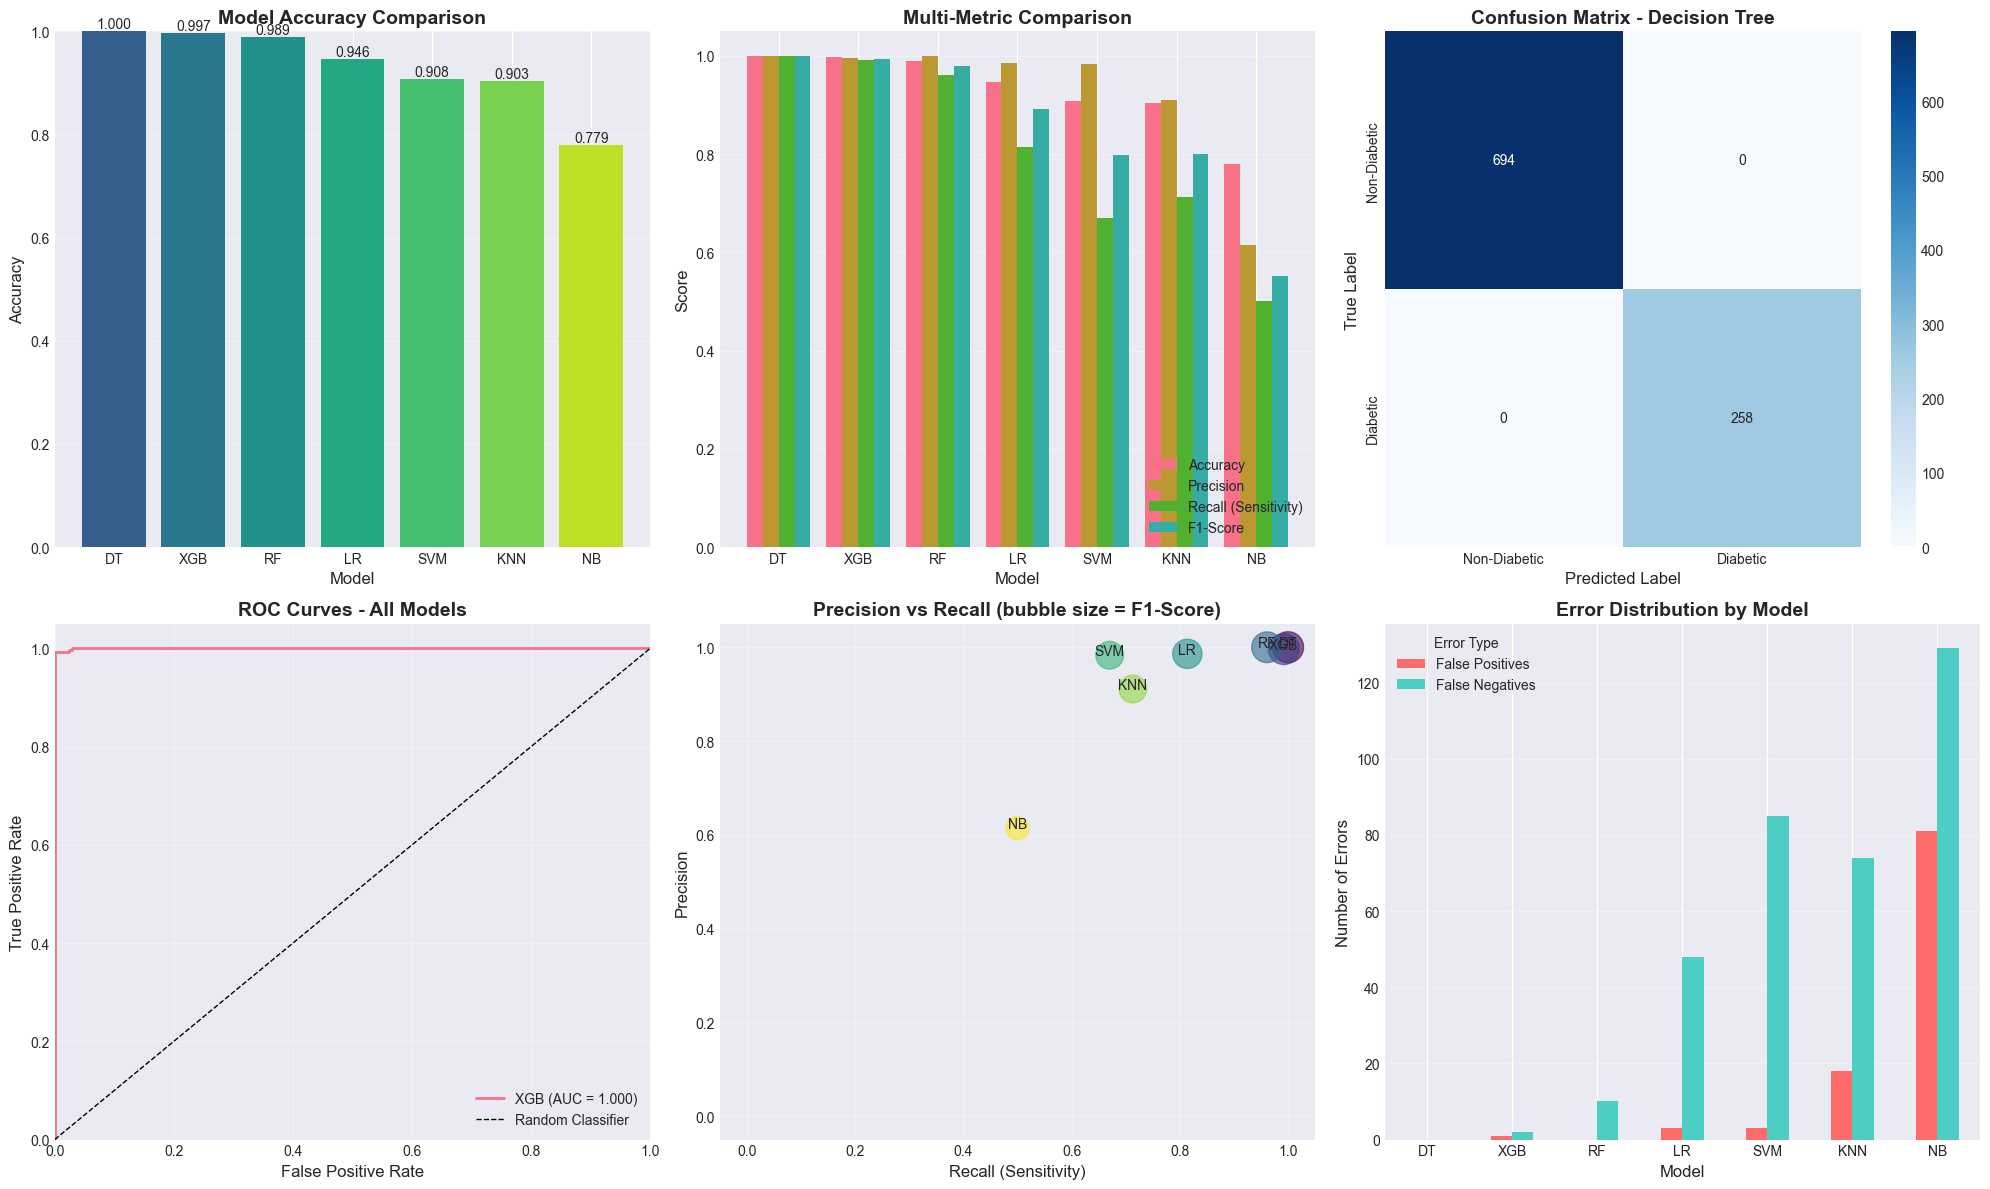

✓ Visualizations saved as 'model_comparison_complete.png'


In [58]:
# ============================================================================
# STEP 4: VISUALIZATIONS
# ============================================================================
print("\n📊 Generating visualizations...")

# Create a figure with subplots
fig = plt.figure(figsize=(20, 12))

# --- 1. Bar Chart: Accuracy Comparison ---
ax1 = plt.subplot(2, 3, 1)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(results_df)))
bars = ax1.bar(results_df['Abbreviation'], results_df['Accuracy'], color=colors)
ax1.set_xlabel('Model', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# --- 2. Multi-metric Comparison ---
ax2 = plt.subplot(2, 3, 2)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall (Sensitivity)', 'F1-Score']
x = np.arange(len(results_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    offset = (i - len(metrics_to_plot)/2) * width + width/2
    ax2.bar(x + offset, results_df[metric], width, label=metric)

ax2.set_xlabel('Model', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Multi-Metric Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(results_df['Abbreviation'])
ax2.legend(loc='lower right')
ax2.grid(axis='y', alpha=0.3)

# --- 3. Confusion Matrix Heatmap (Best Model) ---
ax3 = plt.subplot(2, 3, 3)
best_model_name = best_model['Model']
best_pred = models[best_model_name]['predictions']
cm_best = confusion_matrix(y_test, best_pred)

sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Diabetic', 'Diabetic'],
            yticklabels=['Non-Diabetic', 'Diabetic'], ax=ax3)
ax3.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax3.set_ylabel('True Label', fontsize=12)
ax3.set_xlabel('Predicted Label', fontsize=12)

# --- 4. ROC Curves ---
ax4 = plt.subplot(2, 3, 4)
roc_data = []

for name, model_info in models.items():
    model = model_info['model']
    
    # Get probability predictions
    try:
        if name == 'SVM':
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if 'X_test_scaled' in globals() else model.predict_proba(X_test)[:, 1]
        else:
            y_pred_proba = model.predict_proba(X_test)[:, 1]
    except:
        # If predict_proba not available, use decision_function
        try:
            if name == 'SVM':
                y_pred_proba = model.decision_function(X_test_scaled) if 'X_test_scaled' in globals() else model.decision_function(X_test)
            else:
                y_pred_proba = model.decision_function(X_test)
        except:
            continue
    
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    roc_data.append({'Model': name, 'AUC': roc_auc})
    
    ax4.plot(fpr, tpr, label=f'{model_info["abbrev"]} (AUC = {roc_auc:.3f})', linewidth=2)

ax4.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
ax4.set_xlim([0.0, 1.0])
ax4.set_ylim([0.0, 1.05])
ax4.set_xlabel('False Positive Rate', fontsize=12)
ax4.set_ylabel('True Positive Rate', fontsize=12)
ax4.set_title('ROC Curves - All Models', fontsize=14, fontweight='bold')
ax4.legend(loc="lower right", fontsize=10)
ax4.grid(alpha=0.3)

# --- 5. Precision-Recall Comparison ---
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(results_df['Recall (Sensitivity)'], results_df['Precision'], 
           s=results_df['F1-Score']*500, alpha=0.6, c=range(len(results_df)), cmap='viridis')

for idx, row in results_df.iterrows():
    ax5.annotate(row['Abbreviation'], 
                (row['Recall (Sensitivity)'], row['Precision']),
                fontsize=10, ha='center')

ax5.set_xlabel('Recall (Sensitivity)', fontsize=12)
ax5.set_ylabel('Precision', fontsize=12)
ax5.set_title('Precision vs Recall (bubble size = F1-Score)', fontsize=14, fontweight='bold')
ax5.grid(alpha=0.3)
ax5.set_xlim([-0.05, 1.05])
ax5.set_ylim([-0.05, 1.05])

# --- 6. Error Analysis ---
ax6 = plt.subplot(2, 3, 6)
error_data = pd.DataFrame({
    'False Positives': results_df['FP'].values,
    'False Negatives': results_df['FN'].values
}, index=results_df['Abbreviation'].values)

error_data.plot(kind='bar', ax=ax6, color=['#ff6b6b', '#4ecdc4'])
ax6.set_xlabel('Model', fontsize=12)
ax6.set_ylabel('Number of Errors', fontsize=12)
ax6.set_title('Error Distribution by Model', fontsize=14, fontweight='bold')
ax6.legend(title='Error Type')
ax6.grid(axis='y', alpha=0.3)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('model_comparison_complete.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved as 'model_comparison_complete.png'")


In [57]:
# ============================================================================
# STEP 5: STATISTICAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("STATISTICAL SUMMARY")
print("="*80)

# AUC Ranking
if roc_data:
    auc_df = pd.DataFrame(roc_data).sort_values('AUC', ascending=False)
    print("\n📊 AUC Ranking:")
    print("-" * 40)
    for idx, row in auc_df.iterrows():
        print(f"{row['Model']}: {row['AUC']:.4f}")

# Model consensus
print("\n🤝 Model Consensus Analysis:")
print("-" * 40)
agreement_matrix = np.zeros((len(y_test), len(models)))
for i, (name, model_info) in enumerate(models.items()):
    agreement_matrix[:, i] = model_info['predictions']

consensus = np.mean(agreement_matrix, axis=1)
print(f"Average agreement rate: {np.mean(consensus == consensus.round()):.2%}")



STATISTICAL SUMMARY

📊 AUC Ranking:
----------------------------------------
XGBoost: 0.9998

🤝 Model Consensus Analysis:
----------------------------------------
Average agreement rate: 73.42%


In [59]:
# ============================================================================
# STEP 6: SAVE RESULTS
# ============================================================================
print("\n💾 Saving results...")

# Save detailed results
results_df.to_csv('model_comparison_detailed.csv', index=False)
print("✓ Detailed results saved to 'model_comparison_detailed.csv'")

# Save summary
summary = pd.DataFrame({
    'Metric': ['Best Model', 'Best Accuracy', 'Best F1-Score', 'Best AUC'],
    'Value': [
        best_model['Model'],
        f"{best_model['Accuracy']:.4f}",
        f"{best_model['F1-Score']:.4f}",
        f"{auc_df.iloc[0]['AUC']:.4f}" if roc_data else 'N/A'
    ]
})
summary.to_csv('model_comparison_summary.csv', index=False)
print("✓ Summary saved to 'model_comparison_summary.csv'")

print("\n" + "="*80)
print("✅ MODEL COMPARISON COMPLETE!")
print("="*80)
print("\nKey findings:")
print(f"• Best overall model: {best_model['Model']}")
print(f"• Highest accuracy: {best_model['Accuracy']:.4f}")
print(f"• Most consistent: {results_df.loc[results_df['MCC'].idxmax(), 'Model']} (highest MCC)")
print(f"• Best for avoiding false positives: {results_df.loc[results_df['Precision'].idxmax(), 'Model']}")
print(f"• Best for catching all diabetics: {results_df.loc[results_df['Recall (Sensitivity)'].idxmax(), 'Model']}")
print("="*80)


💾 Saving results...
✓ Detailed results saved to 'model_comparison_detailed.csv'
✓ Summary saved to 'model_comparison_summary.csv'

✅ MODEL COMPARISON COMPLETE!

Key findings:
• Best overall model: Decision Tree
• Highest accuracy: 1.0000
• Most consistent: Decision Tree (highest MCC)
• Best for avoiding false positives: Decision Tree
• Best for catching all diabetics: Decision Tree


✓ TensorFlow/Keras imported successfully

3.8 KERAS DEEP NEURAL NETWORK (DNN)

📊 Preparing data for DNN...
✓ Data scaled for DNN
Input dimension: 20
Training samples: 3804
Test samples: 952

🏗️ Building DNN architecture...

Model Architecture:
--------------------------------------------------
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 128)               2688      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                       

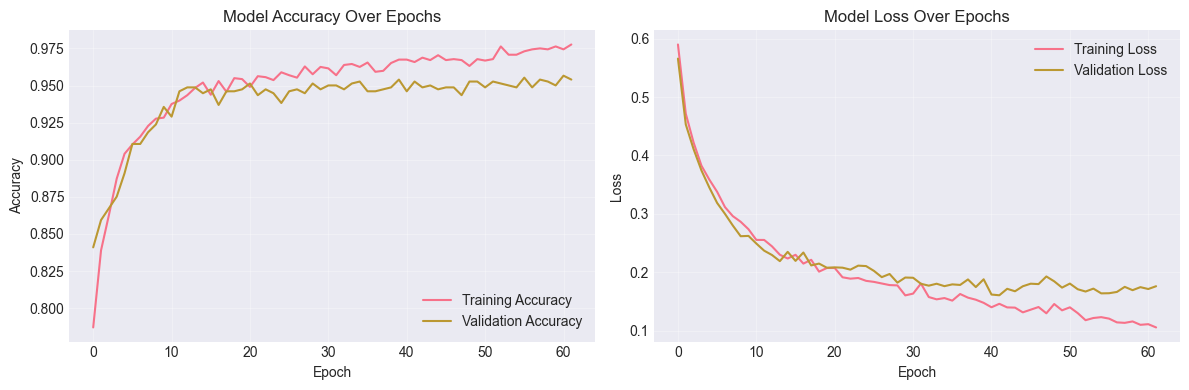

✓ Training history saved as 'dnn_training_history.png'

📈 Generating ROC curve...


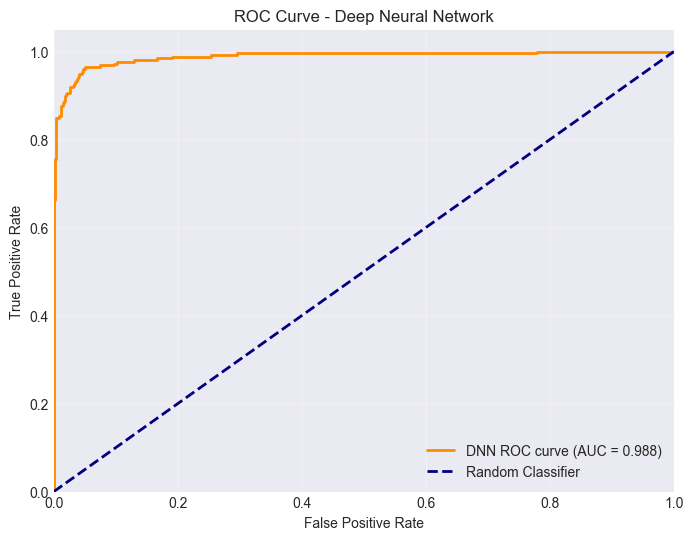

✓ ROC curve saved. AUC: 0.9884

🔄 Adding DNN to model comparison...
✓ DNN model saved as 'DNN'
✓ Predictions saved as 'y_pred_dnn'

DEEP NEURAL NETWORK TRAINING COMPLETE!
Final Test Accuracy: 0.9569
Final Test F1-Score: 0.9194
ROC AUC Score: 0.9884

Model is ready for comparison with other algorithms.
You can now include DNN in your model comparison by running the comparison code again.


In [61]:
# ============================================================================
# KERAS DEEP NEURAL NETWORK (DNN) FOR T2DM PREDICTION
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Import Keras/TensorFlow
try:
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.regularizers import l2
    print("✓ TensorFlow/Keras imported successfully")
except ImportError:
    print("⚠️ TensorFlow not installed. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow"])
    from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
    from tensorflow.keras.regularizers import l2

print("\n" + "="*80)
print("3.8 KERAS DEEP NEURAL NETWORK (DNN)")
print("="*80)

# ============================================================================
# STEP 1: DATA PREPARATION
# ============================================================================
print("\n📊 Preparing data for DNN...")

# Check if scaled data exists (recommended for neural networks)
try:
    X_train_dnn = X_train_scaled.values if hasattr(X_train_scaled, 'values') else X_train_scaled
    X_test_dnn = X_test_scaled.values if hasattr(X_test_scaled, 'values') else X_test_scaled
    print("✓ Using scaled data (recommended for DNN)")
except:
    # If scaled data doesn't exist, scale it now
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_dnn = scaler.fit_transform(X_train_use)
    X_test_dnn = scaler.transform(X_test_use)
    print("✓ Data scaled for DNN")

# Ensure y is numpy array and correct shape
y_train_dnn = np.array(y_train).astype(int)
y_test_dnn = np.array(y_test).astype(int)

# Get input dimension
input_dim = X_train_dnn.shape[1]
print(f"Input dimension: {input_dim}")
print(f"Training samples: {X_train_dnn.shape[0]}")
print(f"Test samples: {X_test_dnn.shape[0]}")

# ============================================================================
# STEP 2: BUILD DNN MODEL
# ============================================================================
print("\n🏗️ Building DNN architecture...")

def create_dnn_model(input_dim, learning_rate=0.001):
    """
    Create a Deep Neural Network for binary classification
    
    Architecture:
    - Input layer
    - Hidden layer 1: 128 neurons with ReLU
    - Dropout layer: 0.3
    - Hidden layer 2: 64 neurons with ReLU
    - Batch Normalization
    - Dropout layer: 0.2
    - Hidden layer 3: 32 neurons with ReLU
    - Output layer: 1 neuron with sigmoid (binary classification)
    """
    
    model = Sequential([
        # First hidden layer
        Dense(128, activation='relu', input_dim=input_dim, 
              kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        
        # Second hidden layer
        Dense(64, activation='relu', 
              kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.2),
        
        # Third hidden layer
        Dense(32, activation='relu'),
        Dropout(0.1),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the model
DNN = create_dnn_model(input_dim)

# Display model architecture
print("\nModel Architecture:")
print("-" * 50)
DNN.summary()

# ============================================================================
# STEP 3: TRAIN MODEL WITH CALLBACKS
# ============================================================================
print("\n🎯 Training DNN model...")

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

# Train the model
history = DNN.fit(
    X_train_dnn, y_train_dnn,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=200,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=0  # Set to 1 to see training progress
)

print(f"✓ Training completed in {len(history.history['loss'])} epochs")

# ============================================================================
# STEP 4: EVALUATE MODEL
# ============================================================================
print("\n📈 Evaluating DNN performance...")

# Make predictions
y_pred_dnn_prob = DNN.predict(X_test_dnn).flatten()
y_pred_dnn = (y_pred_dnn_prob > 0.5).astype(int)

# Calculate metrics
accuracy_dnn = accuracy_score(y_test_dnn, y_pred_dnn)
precision_dnn = precision_score(y_test_dnn, y_pred_dnn, zero_division=0)
recall_dnn = recall_score(y_test_dnn, y_pred_dnn, zero_division=0)
f1_dnn = f1_score(y_test_dnn, y_pred_dnn, zero_division=0)

print(f'\nAccuracy for testing: {accuracy_dnn:.4f}')
print(f'Precision: {precision_dnn:.4f}')
print(f'Recall: {recall_dnn:.4f}')
print(f'F1-Score: {f1_dnn:.4f}')

print("\nConfusion Matrix:")
cm_dnn = confusion_matrix(y_test_dnn, y_pred_dnn)
print(cm_dnn)

print("\nClassification Report:")
print(classification_report(y_test_dnn, y_pred_dnn, digits=4))

# Store confusion matrix
cf_matrix_DNN = cm_dnn

# ============================================================================
# STEP 5: CROSS-VALIDATION (Optional - takes longer)
# ============================================================================
print("\n🔄 Performing cross-validation (this may take a minute)...")

# Simplified cross-validation
cv_scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=2)

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_dnn), 1):
    # Create a new model for each fold
    model_cv = create_dnn_model(input_dim)
    
    # Get fold data
    X_fold_train, X_fold_val = X_train_dnn[train_idx], X_train_dnn[val_idx]
    y_fold_train, y_fold_val = y_train_dnn[train_idx], y_train_dnn[val_idx]
    
    # Train model
    model_cv.fit(
        X_fold_train, y_fold_train,
        epochs=50,  # Fewer epochs for CV
        batch_size=32,
        verbose=0
    )
    
    # Evaluate
    y_pred_fold = (model_cv.predict(X_fold_val).flatten() > 0.5).astype(int)
    fold_accuracy = accuracy_score(y_fold_val, y_pred_fold)
    cv_scores.append(fold_accuracy)
    print(f"Fold {fold}: {fold_accuracy:.4f}")

print(f"\nCross-validation accuracy: {np.mean(cv_scores):.4f} (+/- {np.std(cv_scores):.4f})")

# ============================================================================
# STEP 6: VISUALIZE TRAINING HISTORY
# ============================================================================
print("\n📊 Generating training visualizations...")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy Over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot training & validation loss
axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss Over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('dnn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history saved as 'dnn_training_history.png'")

# ============================================================================
# STEP 7: ROC CURVE
# ============================================================================
print("\n📈 Generating ROC curve...")

fpr_dnn, tpr_dnn, _ = roc_curve(y_test_dnn, y_pred_dnn_prob)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_dnn, tpr_dnn, color='darkorange', lw=2, 
         label=f'DNN ROC curve (AUC = {roc_auc_dnn:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Deep Neural Network')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.savefig('dnn_roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ ROC curve saved. AUC: {roc_auc_dnn:.4f}")

# ============================================================================
# STEP 8: ADD TO MODEL COMPARISON
# ============================================================================
print("\n🔄 Adding DNN to model comparison...")

# Make sure the model and predictions are available globally
globals()['DNN'] = DNN
globals()['y_pred_dnn'] = y_pred_dnn

print("✓ DNN model saved as 'DNN'")
print("✓ Predictions saved as 'y_pred_dnn'")

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*80)
print("DEEP NEURAL NETWORK TRAINING COMPLETE!")
print("="*80)
print(f"Final Test Accuracy: {accuracy_dnn:.4f}")
print(f"Final Test F1-Score: {f1_dnn:.4f}")
print(f"ROC AUC Score: {roc_auc_dnn:.4f}")
print("\nModel is ready for comparison with other algorithms.")
print("You can now include DNN in your model comparison by running the comparison code again.")
print("="*80)